<a href="https://colab.research.google.com/github/ReyFrank92/joyofcoding/blob/main/Copia_de_Full_4_de_AR_NN_Mezcla_Mexicana_4%20neuronas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install TensorFlow
!pip install -q tensorflow-gpu==2.9.1
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 1.6 MB 38.5 MB/s 
     |████████████████████████████████| 5.8 MB 16.8 MB/s 
     |████████████████████████████████| 438 kB 57.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.1 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.9.0 which is incompatible.
2.9.1


In [2]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense,  GRU, LSTM, GlobalMaxPool1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [3]:
from google.colab import files
data_to_load = files.upload()

Saving Mezcla Mexicana Resumen.csv to Mezcla Mexicana Resumen.csv


In [4]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
np.random.seed(0)
tf.random.set_seed(0)

In [6]:
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hideen units 
# K = number of output units

In [7]:
from sklearn.metrics import mean_absolute_percentage_error

In [8]:
df = pd.read_csv('Mezcla Mexicana Resumen.csv', index_col='Fecha', parse_dates=True)

In [9]:
df['LogMM'] = np.log(df['MM'])

In [10]:
Ntest = 70
train = df.iloc[:-Ntest] #todos -12
test = df.iloc[-Ntest:] #solo las últimas 12 observaciones

In [11]:
from typing import ValuesView
ValuesView(df)

ValuesView(                MM     LogMM
Fecha                       
1996-01-31   15.12  2.716018
1996-02-29   16.82  2.822569
1996-03-29   18.35  2.909630
1996-04-30   17.61  2.868467
1996-05-31   16.48  2.802148
...            ...       ...
2022-02-28   91.80  4.519612
2022-03-31   98.00  4.584967
2022-04-29  102.02  4.625169
2022-05-31  113.83  4.734706
2022-06-30  104.79  4.651958

[318 rows x 2 columns])

In [12]:
ValuesView(train)

ValuesView(               MM     LogMM
Fecha                      
1996-01-31  15.12  2.716018
1996-02-29  16.82  2.822569
1996-03-29  18.35  2.909630
1996-04-30  17.61  2.868467
1996-05-31  16.48  2.802148
...           ...       ...
2016-04-29  37.58  3.626472
2016-05-31  40.26  3.695358
2016-06-30  41.00  3.713572
2016-07-29  35.92  3.581294
2016-08-31  38.96  3.662535

[248 rows x 2 columns])

In [13]:
ValuesView(test)

ValuesView(                MM     LogMM
Fecha                       
2016-09-30   39.83  3.684620
2016-10-31   38.81  3.658678
2016-11-30   40.94  3.712108
2016-12-30   46.30  3.835142
2017-01-31   45.18  3.810655
...            ...       ...
2022-02-28   91.80  4.519612
2022-03-31   98.00  4.584967
2022-04-29  102.02  4.625169
2022-05-31  113.83  4.734706
2022-06-30  104.79  4.651958

[70 rows x 2 columns])

In [14]:
# boolean series to index df rows []
train_idx = df.index <= train.index[-1] #pone true a lo que sea train del data set y lo demás false
test_idx = df.index > train.index[-1] # pone true a lo que sea del test solamente y lo demás false

In [15]:
ValuesView(test_idx)

ValuesView(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       Fa

In [16]:
df['DiffLogMM'] = df['LogMM'].diff() #crea una nueva columna con la diferencia del logaritmo de los pasajeros

In [17]:
#Make supervised dataset
series = df['DiffLogMM'].dropna().to_numpy() #son 143/144 datos

T = 4
X = []
Y = []
for t in range(len(series) - T): #corre en el rango de 144-10 = 134
  x = series[t:t+T] #e.g. si t =1 entonces corre de 1 a 11
  X.append(x) #agrega lo anterior
  y = series[t+T] # e.g. si t = 1 entonces y es 11
  Y.append(y) #aagrega lo anterior

X = np.array(X).reshape(-1,T,1) #el tensor es una caja
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape",Y.shape)

X.shape (313, 4, 1) Y.shape (313,)


In [18]:
ValuesView(series)

ValuesView(array([ 1.06550284e-01,  8.70609200e-02, -4.11626520e-02, -6.63193980e-02,
        5.66188940e-02, -1.61853244e-02,  1.03435587e-01,  1.09398594e-01,
       -3.06097547e-02,  2.06688444e-02,  2.81444468e-02, -8.34017193e-02,
       -2.03355711e-01,  6.75470791e-03, -6.13875470e-03,  2.97261803e-02,
       -6.48175001e-02,  4.06178921e-02, -7.96345444e-02,  1.44249609e-01,
       -9.22728577e-03, -1.12726318e-01, -1.98798979e-01, -2.32103256e-02,
       -1.68011481e-01, -2.81708770e-02,  5.46374502e-02,  6.58785744e-02,
       -1.01969861e-01,  3.86100866e-03, -9.91711885e-02,  2.45029947e-01,
       -1.53595741e-01, -2.23143551e-01, -1.21432923e-03,  8.60996614e-02,
       -3.05626504e-02,  3.91575996e-01,  1.30905571e-01, -1.22394881e-01,
        1.54590821e-01,  1.13446547e-01,  1.14569602e-01,  1.16906842e-01,
       -1.19537730e-01,  1.33465532e-01,  1.64612771e-02,  6.92044893e-02,
        1.01332099e-01, -1.63306553e-01, -3.15599026e-02,  1.49893090e-01,
        8.6544

In [19]:
Xtrain, Ytrain = X[: -Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [20]:
print(Xtrain.shape)

(243, 4, 1)


In [21]:
print(Ytrain.shape)

(243,)


In [22]:
print(Xtest.shape) 

(70, 4, 1)


In [23]:
print(Ytest.shape)

(70,)


In [24]:
295+12

307

In [25]:
#RNN 
i = Input(shape=(T,1))
x = LSTM(12)(i)
x = Dense(1)(x)
model = Model(i,x)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 12)                672       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [28]:
print(Xtrain.shape, Ytrain.shape)

(243, 4, 1) (243,)


In [29]:
print(Xtest.shape, Ytest.shape)

(70, 4, 1) (70,)


In [30]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=1000,
    validation_data=(Xtest,Ytest),
)

Epoch 1/1000
8/8 [==============================] - 3s 84ms/step - loss: 0.0133 - val_loss: 0.0453
Epoch 2/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0132 - val_loss: 0.0453
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0131 - val_loss: 0.0455
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0131 - val_loss: 0.0457
Epoch 5/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0131 - val_loss: 0.0457
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0458
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0459
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0129 - val_loss: 0.0460
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0460
Epoch 10/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0128 - val_loss: 0.0460
Epoch 11/1000
8

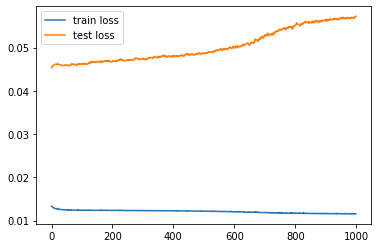

In [31]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [32]:
train_idx[:T+1] = False # First T+1 values are not predictable

In [33]:
print(train_idx[:T+1]) #Me imprime lo que tenemos False en el entrenamiento 

[False False False False False]


In [34]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

3/3 [==============================] - 0s 4ms/step


In [35]:
print(Ptrain.shape)

(243,)


In [36]:
print(Ptest.shape)

(70,)


In [37]:
print(series.shape)

(317,)


In [38]:
237+70+10

317

In [39]:
143-121-12 #es 10 porque el T = 10. 

10

In [40]:
#Needed to compute un-differenced predictions
df['ShiftLogMM'] = df['LogMM'].shift(1) #cambia 1 periodo hacia adelante los datos
prev = df['ShiftLogMM']
ValuesView(prev.tail())

ValuesView(Fecha
2022-02-28    4.420165
2022-03-31    4.519612
2022-04-29    4.584967
2022-05-31    4.625169
2022-06-30    4.734706
Name: ShiftLogMM, dtype: float64)

In [41]:
print(prev.shape)

(318,)


In [42]:
# Last-known train value
last_train = train.iloc[-1]['LogMM']

In [43]:
ValuesView(last_train)

ValuesView(3.6625354787743345)

In [44]:
print(Ptrain.shape, prev[train_idx].shape)

(243,) (243,)


In [45]:
# 1-step forecast[]
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain #Te regresa las 121 observaciones con true //con el loc me regresa del df algo en específico //prev[train_idx] =121 lenght + 121 lenght ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest #Te regresa las 12 observaciones con true // prev[test_idx] 12 lenght + ptest 12 lenght

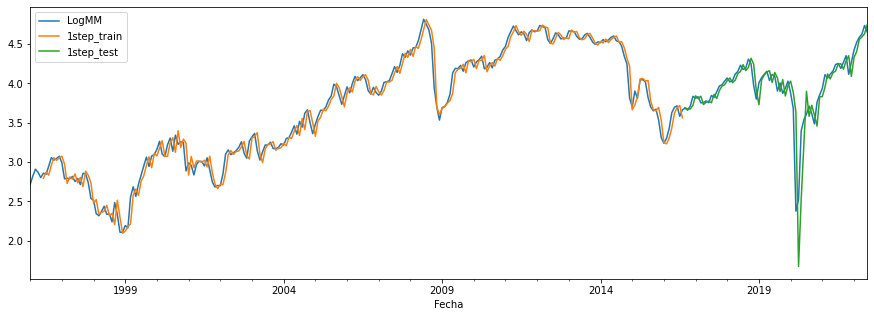

In [46]:
# Plot 1-step forecast []
df[['LogMM','1step_train','1step_test']].plot(figsize=(15,5));

In [47]:
#multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0] #acá hay 10 observaciones

while len(multistep_predictions) < Ntest:#Ntest es 12, entonces el while es hasta 11. Prediceme las sig 12 observaciones. Recuerda que 11 es la 12 porque se incluye el 0
  p = model.predict(last_x.reshape(1,-1, 1))[0]#damelo en 1 fila por x columnas que no se cuantas son. (el que debe de ir es 1,-1)
  #update the predictions list
  multistep_predictions.append(p)#añademe el resultado a p

  #make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

1/1 [==============================] - 0s 17ms/step


In [48]:
print(p)

[-0.00326155]


In [49]:
#save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

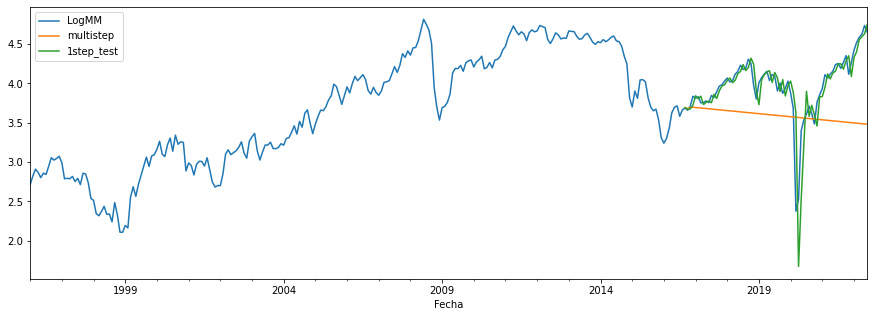

In [50]:
#plot 1-step and multi-step forecast
df[['LogMM','multistep','1step_test']].plot(figsize=(15,5));

In [51]:
# make multi-output supevised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series)- Tx -Ty +1):
  x = series[t:t+Tx] #si t es 1 enotnces corre de 1 a 11
  X.append(x)
  y =series[t+Tx:t+Tx+Ty] #si t es 1, entonces corre de 11 a (1+10+12 = 23)
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (244, 4, 1) Y.shape (244, 70)


In [52]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [53]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(36, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model = Model(i,x)

In [54]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 36)             5472      
                                                                 
 global_max_pooling1d (Globa  (None, 36)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 70)                2590      
                                                                 
Total params: 8,062
Trainable params: 8,062
Non-trainable params: 0
_________________________________________________________________


In [55]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss',save_best_only=True
)

In [56]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [57]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m, Ytest_m),
    callbacks=[check_point],
)

Epoch 1/1000
8/8 [==============================] - 2s 72ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 3/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0158 - val_loss: 0.0462
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 11/1000
8/8

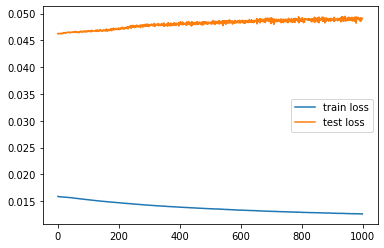

In [58]:
#Plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [59]:
#load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [60]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 16ms/step


In [61]:
Ptrain.shape, Ptest.shape

((243, 70), (1, 70))

In [62]:
Ptrain = Ptrain[:,0]
Ptest = Ptest [0]

In [63]:
print(Ptest)

[ 0.04592821  0.01674469 -0.0059129  -0.09351984 -0.02876313  0.00910401
  0.02371249  0.01921455  0.0089137   0.02789221  0.00823772  0.05637503
 -0.00098086 -0.02070345 -0.03562162  0.01547322  0.00573684 -0.00756896
 -0.00506854 -0.0255367   0.0133498   0.02196113 -0.01053427 -0.06118692
  0.00475276 -0.04662313  0.01024907  0.05683385 -0.04080263 -0.0039378
  0.00811592  0.04814953  0.0609816   0.00795898  0.00693429  0.00236061
  0.03436805 -0.032316    0.01381183  0.00766324  0.04556153 -0.00074744
 -0.0046744  -0.00855146 -0.01127277  0.02825805  0.02786893  0.00463077
 -0.02578987 -0.00765343 -0.02424006 -0.01846127  0.03146777 -0.00950186
 -0.0295117   0.09395786 -0.0180666  -0.01916074  0.02572956  0.00505068
  0.01257624 -0.0138339   0.08183359 -0.01567573 -0.03533272 -0.0566115
 -0.02810277  0.04253824  0.06242535  0.00261158]


In [64]:
# save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

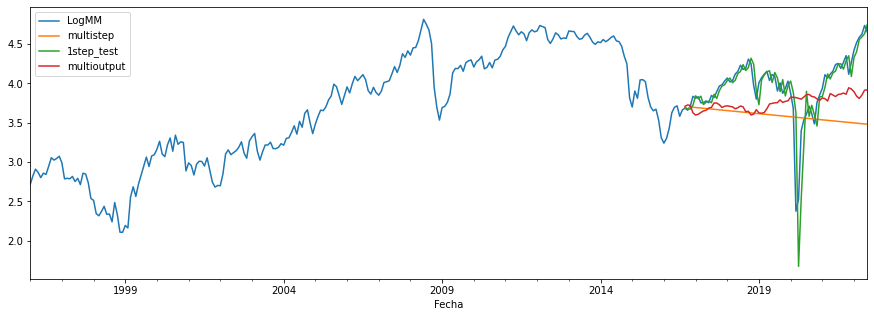

In [65]:
#plot all forecasts
cols = ['LogMM', 'multistep', '1step_test','multioutput']
df[cols].plot(figsize=(15,5));

In [66]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(2, return_sequences=True)(i)
x = LSTM(2, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model2 = Model(i,x)

In [67]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(3, return_sequences=True)(i)
x = LSTM(3, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model3 = Model(i,x)

In [68]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(4, return_sequences=True)(i)
x = LSTM(4, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model4 = Model(i,x)

In [69]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(5, return_sequences=True)(i)
x = LSTM(5, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model5 = Model(i,x)

In [70]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(6, return_sequences=True)(i)
x = LSTM(6, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model6 = Model(i,x)

In [71]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(7, return_sequences=True)(i)
x = LSTM(7, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model7 = Model(i,x)

In [72]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(8, return_sequences=True)(i)
x = LSTM(8, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model8 = Model(i,x)

In [73]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(9, return_sequences=True)(i)
x = LSTM(9, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model9 = Model(i,x)

In [74]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(10, return_sequences=True)(i)
x = LSTM(10, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model10 = Model(i,x)

In [75]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(11, return_sequences=True)(i)
x = LSTM(11, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model11 = Model(i,x)

In [76]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(12, return_sequences=True)(i)
x = LSTM(12, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model12 = Model(i,x)

In [77]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(13, return_sequences=True)(i)
x = LSTM(13, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model13 = Model(i,x)

In [78]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(14, return_sequences=True)(i)
x = LSTM(14, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model14 = Model(i,x)

In [79]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(15, return_sequences=True)(i)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model15 = Model(i,x)

In [80]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model16 = Model(i,x)

In [81]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(17, return_sequences=True)(i)
x = LSTM(17, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model17 = Model(i,x)

In [82]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(18, return_sequences=True)(i)
x = LSTM(18, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model18 = Model(i,x)

In [83]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(19, return_sequences=True)(i)
x = LSTM(19, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model19 = Model(i,x)

In [84]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(20, return_sequences=True)(i)
x = LSTM(20, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model20 = Model(i,x)

In [85]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(21, return_sequences=True)(i)
x = LSTM(21, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model21 = Model(i,x)

In [86]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(22, return_sequences=True)(i)
x = LSTM(22, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model22 = Model(i,x)

In [87]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(23, return_sequences=True)(i)
x = LSTM(23, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model23 = Model(i,x)

In [88]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(24, return_sequences=True)(i)
x = LSTM(24, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model24 = Model(i,x)

In [89]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(25, return_sequences=True)(i)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model25 = Model(i,x)

In [90]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(26, return_sequences=True)(i)
x = LSTM(26, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model26 = Model(i,x)

In [91]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(27, return_sequences=True)(i)
x = LSTM(27, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model27 = Model(i,x)

In [92]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(28, return_sequences=True)(i)
x = LSTM(28, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model28 = Model(i,x)

In [93]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(29, return_sequences=True)(i)
x = LSTM(29, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model29 = Model(i,x)

In [94]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(30, return_sequences=True)(i)
x = LSTM(30, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model30 = Model(i,x)

In [95]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(31, return_sequences=True)(i)
x = LSTM(31, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model31 = Model(i,x)

In [96]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(32, return_sequences=True)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model32 = Model(i,x)

In [97]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(33, return_sequences=True)(i)
x = LSTM(33, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model33 = Model(i,x)

In [98]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(34, return_sequences=True)(i)
x = LSTM(34, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model34 = Model(i,x)

In [99]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(35, return_sequences=True)(i)
x = LSTM(35, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model35 = Model(i,x)

In [100]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(36, return_sequences=True)(i)
x = LSTM(36, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model36 = Model(i,x)

In [101]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(2, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model2a = Model(i,x)

In [102]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(3, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model3a = Model(i,x)

In [103]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(4, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model4a = Model(i,x)

In [104]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(5, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model5a = Model(i,x)

In [105]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(6, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model6a = Model(i,x)

In [106]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(7, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model7a = Model(i,x)

In [107]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(8, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model8a = Model(i,x)

In [108]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(9, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model9a = Model(i,x)

In [109]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(10, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model10a = Model(i,x)

In [110]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(11, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model11a = Model(i,x)

In [111]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(12, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model12a = Model(i,x)

In [112]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(13, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model13a = Model(i,x)

In [113]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(14, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model14a = Model(i,x)

In [114]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(15, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model15a = Model(i,x)

In [115]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(16, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model16a = Model(i,x)

In [116]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(17, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model17a = Model(i,x)

In [117]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(18, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model18a = Model(i,x)

In [118]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(19, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model19a = Model(i,x)

In [119]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(20, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model20a = Model(i,x)

In [120]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(21, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model21a = Model(i,x)

In [121]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(22, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model22a = Model(i,x)

In [122]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(23, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model23a = Model(i,x)

In [123]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model24a = Model(i,x)

In [124]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(25, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model25a = Model(i,x)

In [125]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(26, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model26a = Model(i,x)

In [126]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(27, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model27a = Model(i,x)

In [127]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(28, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model28a = Model(i,x)

In [128]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(29, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model29a = Model(i,x)

In [129]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(30, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model30a = Model(i,x)

In [130]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(31, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model31a = Model(i,x)

In [131]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model32a = Model(i,x)

In [132]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(33, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model33a = Model(i,x)

In [133]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(34, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model34a = Model(i,x)

In [134]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(35, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model35a = Model(i,x)

In [135]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(36, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model36a = Model(i,x)

In [136]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 2)              32        
                                                                 
 lstm_3 (LSTM)               (None, 4, 2)              40        
                                                                 
 global_max_pooling1d_1 (Glo  (None, 2)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 70)                210       
                                                                 
Total params: 282
Trainable params: 282
Non-trainable params: 0
_____________________________________________________________

In [137]:
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 4, 3)              60        
                                                                 
 lstm_5 (LSTM)               (None, 4, 3)              84        
                                                                 
 global_max_pooling1d_2 (Glo  (None, 3)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 70)                280       
                                                                 
Total params: 424
Trainable params: 424
Non-trainable params: 0
_____________________________________________________________

In [138]:
model4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 4, 4)              96        
                                                                 
 lstm_7 (LSTM)               (None, 4, 4)              144       
                                                                 
 global_max_pooling1d_3 (Glo  (None, 4)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 70)                350       
                                                                 
Total params: 590
Trainable params: 590
Non-trainable params: 0
_____________________________________________________________

In [139]:
model5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 4, 5)              140       
                                                                 
 lstm_9 (LSTM)               (None, 4, 5)              220       
                                                                 
 global_max_pooling1d_4 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 70)                420       
                                                                 
Total params: 780
Trainable params: 780
Non-trainable params: 0
_____________________________________________________________

In [140]:
model6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 4, 6)              192       
                                                                 
 lstm_11 (LSTM)              (None, 4, 6)              312       
                                                                 
 global_max_pooling1d_5 (Glo  (None, 6)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 70)                490       
                                                                 
Total params: 994
Trainable params: 994
Non-trainable params: 0
_____________________________________________________________

In [141]:
model7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 4, 7)              252       
                                                                 
 lstm_13 (LSTM)              (None, 4, 7)              420       
                                                                 
 global_max_pooling1d_6 (Glo  (None, 7)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 70)                560       
                                                                 
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
_________________________________________________________

In [142]:
model8.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 lstm_14 (LSTM)              (None, 4, 8)              320       
                                                                 
 lstm_15 (LSTM)              (None, 4, 8)              544       
                                                                 
 global_max_pooling1d_7 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 70)                630       
                                                                 
Total params: 1,494
Trainable params: 1,494
Non-trainable params: 0
_________________________________________________________

In [143]:
model9.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 4, 9)              396       
                                                                 
 lstm_17 (LSTM)              (None, 4, 9)              684       
                                                                 
 global_max_pooling1d_8 (Glo  (None, 9)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 70)                700       
                                                                 
Total params: 1,780
Trainable params: 1,780
Non-trainable params: 0
_________________________________________________________

In [144]:
model10.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_18 (LSTM)              (None, 4, 10)             480       
                                                                 
 lstm_19 (LSTM)              (None, 4, 10)             840       
                                                                 
 global_max_pooling1d_9 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 70)                770       
                                                                 
Total params: 2,090
Trainable params: 2,090
Non-trainable params: 0
________________________________________________________

In [145]:
model11.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 4, 11)             572       
                                                                 
 lstm_21 (LSTM)              (None, 4, 11)             1012      
                                                                 
 global_max_pooling1d_10 (Gl  (None, 11)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_11 (Dense)            (None, 70)                840       
                                                                 
Total params: 2,424
Trainable params: 2,424
Non-trainable params: 0
________________________________________________________

In [146]:
model12.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_22 (LSTM)              (None, 4, 12)             672       
                                                                 
 lstm_23 (LSTM)              (None, 4, 12)             1200      
                                                                 
 global_max_pooling1d_11 (Gl  (None, 12)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 70)                910       
                                                                 
Total params: 2,782
Trainable params: 2,782
Non-trainable params: 0
________________________________________________________

In [147]:
model13.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_24 (LSTM)              (None, 4, 13)             780       
                                                                 
 lstm_25 (LSTM)              (None, 4, 13)             1404      
                                                                 
 global_max_pooling1d_12 (Gl  (None, 13)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_13 (Dense)            (None, 70)                980       
                                                                 
Total params: 3,164
Trainable params: 3,164
Non-trainable params: 0
________________________________________________________

In [148]:
model14.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_26 (LSTM)              (None, 4, 14)             896       
                                                                 
 lstm_27 (LSTM)              (None, 4, 14)             1624      
                                                                 
 global_max_pooling1d_13 (Gl  (None, 14)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 70)                1050      
                                                                 
Total params: 3,570
Trainable params: 3,570
Non-trainable params: 0
________________________________________________________

In [149]:
model15.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_28 (LSTM)              (None, 4, 15)             1020      
                                                                 
 lstm_29 (LSTM)              (None, 4, 15)             1860      
                                                                 
 global_max_pooling1d_14 (Gl  (None, 15)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_15 (Dense)            (None, 70)                1120      
                                                                 
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
________________________________________________________

In [150]:
model16.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_30 (LSTM)              (None, 4, 16)             1152      
                                                                 
 lstm_31 (LSTM)              (None, 4, 16)             2112      
                                                                 
 global_max_pooling1d_15 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_16 (Dense)            (None, 70)                1190      
                                                                 
Total params: 4,454
Trainable params: 4,454
Non-trainable params: 0
________________________________________________________

In [151]:
model17.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_32 (LSTM)              (None, 4, 17)             1292      
                                                                 
 lstm_33 (LSTM)              (None, 4, 17)             2380      
                                                                 
 global_max_pooling1d_16 (Gl  (None, 17)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_17 (Dense)            (None, 70)                1260      
                                                                 
Total params: 4,932
Trainable params: 4,932
Non-trainable params: 0
________________________________________________________

In [152]:
model18.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_34 (LSTM)              (None, 4, 18)             1440      
                                                                 
 lstm_35 (LSTM)              (None, 4, 18)             2664      
                                                                 
 global_max_pooling1d_17 (Gl  (None, 18)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_18 (Dense)            (None, 70)                1330      
                                                                 
Total params: 5,434
Trainable params: 5,434
Non-trainable params: 0
________________________________________________________

In [153]:
model19.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_36 (LSTM)              (None, 4, 19)             1596      
                                                                 
 lstm_37 (LSTM)              (None, 4, 19)             2964      
                                                                 
 global_max_pooling1d_18 (Gl  (None, 19)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_19 (Dense)            (None, 70)                1400      
                                                                 
Total params: 5,960
Trainable params: 5,960
Non-trainable params: 0
________________________________________________________

In [154]:
model20.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_38 (LSTM)              (None, 4, 20)             1760      
                                                                 
 lstm_39 (LSTM)              (None, 4, 20)             3280      
                                                                 
 global_max_pooling1d_19 (Gl  (None, 20)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 70)                1470      
                                                                 
Total params: 6,510
Trainable params: 6,510
Non-trainable params: 0
________________________________________________________

In [155]:
model21.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_40 (LSTM)              (None, 4, 21)             1932      
                                                                 
 lstm_41 (LSTM)              (None, 4, 21)             3612      
                                                                 
 global_max_pooling1d_20 (Gl  (None, 21)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_21 (Dense)            (None, 70)                1540      
                                                                 
Total params: 7,084
Trainable params: 7,084
Non-trainable params: 0
________________________________________________________

In [156]:
model22.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_42 (LSTM)              (None, 4, 22)             2112      
                                                                 
 lstm_43 (LSTM)              (None, 4, 22)             3960      
                                                                 
 global_max_pooling1d_21 (Gl  (None, 22)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 70)                1610      
                                                                 
Total params: 7,682
Trainable params: 7,682
Non-trainable params: 0
________________________________________________________

In [157]:
model23.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_44 (LSTM)              (None, 4, 23)             2300      
                                                                 
 lstm_45 (LSTM)              (None, 4, 23)             4324      
                                                                 
 global_max_pooling1d_22 (Gl  (None, 23)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_23 (Dense)            (None, 70)                1680      
                                                                 
Total params: 8,304
Trainable params: 8,304
Non-trainable params: 0
________________________________________________________

In [158]:
model24.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_46 (LSTM)              (None, 4, 24)             2496      
                                                                 
 lstm_47 (LSTM)              (None, 4, 24)             4704      
                                                                 
 global_max_pooling1d_23 (Gl  (None, 24)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_24 (Dense)            (None, 70)                1750      
                                                                 
Total params: 8,950
Trainable params: 8,950
Non-trainable params: 0
________________________________________________________

In [159]:
model25.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_48 (LSTM)              (None, 4, 25)             2700      
                                                                 
 lstm_49 (LSTM)              (None, 4, 25)             5100      
                                                                 
 global_max_pooling1d_24 (Gl  (None, 25)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_25 (Dense)            (None, 70)                1820      
                                                                 
Total params: 9,620
Trainable params: 9,620
Non-trainable params: 0
________________________________________________________

In [160]:
model26.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_50 (LSTM)              (None, 4, 26)             2912      
                                                                 
 lstm_51 (LSTM)              (None, 4, 26)             5512      
                                                                 
 global_max_pooling1d_25 (Gl  (None, 26)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_26 (Dense)            (None, 70)                1890      
                                                                 
Total params: 10,314
Trainable params: 10,314
Non-trainable params: 0
______________________________________________________

In [161]:
model27.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_52 (LSTM)              (None, 4, 27)             3132      
                                                                 
 lstm_53 (LSTM)              (None, 4, 27)             5940      
                                                                 
 global_max_pooling1d_26 (Gl  (None, 27)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_27 (Dense)            (None, 70)                1960      
                                                                 
Total params: 11,032
Trainable params: 11,032
Non-trainable params: 0
______________________________________________________

In [162]:
model28.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_54 (LSTM)              (None, 4, 28)             3360      
                                                                 
 lstm_55 (LSTM)              (None, 4, 28)             6384      
                                                                 
 global_max_pooling1d_27 (Gl  (None, 28)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_28 (Dense)            (None, 70)                2030      
                                                                 
Total params: 11,774
Trainable params: 11,774
Non-trainable params: 0
______________________________________________________

In [163]:
model29.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_56 (LSTM)              (None, 4, 29)             3596      
                                                                 
 lstm_57 (LSTM)              (None, 4, 29)             6844      
                                                                 
 global_max_pooling1d_28 (Gl  (None, 29)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_29 (Dense)            (None, 70)                2100      
                                                                 
Total params: 12,540
Trainable params: 12,540
Non-trainable params: 0
______________________________________________________

In [164]:
model30.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_58 (LSTM)              (None, 4, 30)             3840      
                                                                 
 lstm_59 (LSTM)              (None, 4, 30)             7320      
                                                                 
 global_max_pooling1d_29 (Gl  (None, 30)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_30 (Dense)            (None, 70)                2170      
                                                                 
Total params: 13,330
Trainable params: 13,330
Non-trainable params: 0
______________________________________________________

In [165]:
model31.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_60 (LSTM)              (None, 4, 31)             4092      
                                                                 
 lstm_61 (LSTM)              (None, 4, 31)             7812      
                                                                 
 global_max_pooling1d_30 (Gl  (None, 31)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_31 (Dense)            (None, 70)                2240      
                                                                 
Total params: 14,144
Trainable params: 14,144
Non-trainable params: 0
______________________________________________________

In [166]:
model32.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_62 (LSTM)              (None, 4, 32)             4352      
                                                                 
 lstm_63 (LSTM)              (None, 4, 32)             8320      
                                                                 
 global_max_pooling1d_31 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_32 (Dense)            (None, 70)                2310      
                                                                 
Total params: 14,982
Trainable params: 14,982
Non-trainable params: 0
______________________________________________________

In [167]:
model33.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_64 (LSTM)              (None, 4, 33)             4620      
                                                                 
 lstm_65 (LSTM)              (None, 4, 33)             8844      
                                                                 
 global_max_pooling1d_32 (Gl  (None, 33)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_33 (Dense)            (None, 70)                2380      
                                                                 
Total params: 15,844
Trainable params: 15,844
Non-trainable params: 0
______________________________________________________

In [168]:
model34.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_66 (LSTM)              (None, 4, 34)             4896      
                                                                 
 lstm_67 (LSTM)              (None, 4, 34)             9384      
                                                                 
 global_max_pooling1d_33 (Gl  (None, 34)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_34 (Dense)            (None, 70)                2450      
                                                                 
Total params: 16,730
Trainable params: 16,730
Non-trainable params: 0
______________________________________________________

In [169]:
model35.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_68 (LSTM)              (None, 4, 35)             5180      
                                                                 
 lstm_69 (LSTM)              (None, 4, 35)             9940      
                                                                 
 global_max_pooling1d_34 (Gl  (None, 35)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_35 (Dense)            (None, 70)                2520      
                                                                 
Total params: 17,640
Trainable params: 17,640
Non-trainable params: 0
______________________________________________________

In [170]:
model36.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_70 (LSTM)              (None, 4, 36)             5472      
                                                                 
 lstm_71 (LSTM)              (None, 4, 36)             10512     
                                                                 
 global_max_pooling1d_35 (Gl  (None, 36)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_36 (Dense)            (None, 70)                2590      
                                                                 
Total params: 18,574
Trainable params: 18,574
Non-trainable params: 0
______________________________________________________

In [171]:
model2a.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_72 (LSTM)              (None, 4, 2)              32        
                                                                 
 global_max_pooling1d_36 (Gl  (None, 2)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_37 (Dense)            (None, 70)                210       
                                                                 
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


In [172]:
model3a.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_73 (LSTM)              (None, 4, 3)              60        
                                                                 
 global_max_pooling1d_37 (Gl  (None, 3)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_38 (Dense)            (None, 70)                280       
                                                                 
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________


In [173]:
model3a.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_73 (LSTM)              (None, 4, 3)              60        
                                                                 
 global_max_pooling1d_37 (Gl  (None, 3)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_38 (Dense)            (None, 70)                280       
                                                                 
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________


In [174]:
model4a.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_74 (LSTM)              (None, 4, 4)              96        
                                                                 
 global_max_pooling1d_38 (Gl  (None, 4)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_39 (Dense)            (None, 70)                350       
                                                                 
Total params: 446
Trainable params: 446
Non-trainable params: 0
_________________________________________________________________


In [175]:
model5a.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_75 (LSTM)              (None, 4, 5)              140       
                                                                 
 global_max_pooling1d_39 (Gl  (None, 5)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_40 (Dense)            (None, 70)                420       
                                                                 
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


In [176]:
model6a.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_76 (LSTM)              (None, 4, 6)              192       
                                                                 
 global_max_pooling1d_40 (Gl  (None, 6)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_41 (Dense)            (None, 70)                490       
                                                                 
Total params: 682
Trainable params: 682
Non-trainable params: 0
_________________________________________________________________


In [177]:
model7a.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_77 (LSTM)              (None, 4, 7)              252       
                                                                 
 global_max_pooling1d_41 (Gl  (None, 7)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_42 (Dense)            (None, 70)                560       
                                                                 
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


In [178]:
model8a.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_78 (LSTM)              (None, 4, 8)              320       
                                                                 
 global_max_pooling1d_42 (Gl  (None, 8)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_43 (Dense)            (None, 70)                630       
                                                                 
Total params: 950
Trainable params: 950
Non-trainable params: 0
_________________________________________________________________


In [179]:
model8a.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_78 (LSTM)              (None, 4, 8)              320       
                                                                 
 global_max_pooling1d_42 (Gl  (None, 8)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_43 (Dense)            (None, 70)                630       
                                                                 
Total params: 950
Trainable params: 950
Non-trainable params: 0
_________________________________________________________________


In [180]:
model9a.summary()

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_79 (LSTM)              (None, 4, 9)              396       
                                                                 
 global_max_pooling1d_43 (Gl  (None, 9)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_44 (Dense)            (None, 70)                700       
                                                                 
Total params: 1,096
Trainable params: 1,096
Non-trainable params: 0
_________________________________________________________________


In [181]:
model10a.summary()

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_80 (LSTM)              (None, 4, 10)             480       
                                                                 
 global_max_pooling1d_44 (Gl  (None, 10)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_45 (Dense)            (None, 70)                770       
                                                                 
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [182]:
model11a.summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_81 (LSTM)              (None, 4, 11)             572       
                                                                 
 global_max_pooling1d_45 (Gl  (None, 11)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_46 (Dense)            (None, 70)                840       
                                                                 
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________


In [183]:
model12a.summary()

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_82 (LSTM)              (None, 4, 12)             672       
                                                                 
 global_max_pooling1d_46 (Gl  (None, 12)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_47 (Dense)            (None, 70)                910       
                                                                 
Total params: 1,582
Trainable params: 1,582
Non-trainable params: 0
_________________________________________________________________


In [184]:
model13a.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_83 (LSTM)              (None, 4, 13)             780       
                                                                 
 global_max_pooling1d_47 (Gl  (None, 13)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_48 (Dense)            (None, 70)                980       
                                                                 
Total params: 1,760
Trainable params: 1,760
Non-trainable params: 0
_________________________________________________________________


In [185]:
model14a.summary()

Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_84 (LSTM)              (None, 4, 14)             896       
                                                                 
 global_max_pooling1d_48 (Gl  (None, 14)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_49 (Dense)            (None, 70)                1050      
                                                                 
Total params: 1,946
Trainable params: 1,946
Non-trainable params: 0
_________________________________________________________________


In [186]:
model15a.summary()

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_85 (LSTM)              (None, 4, 15)             1020      
                                                                 
 global_max_pooling1d_49 (Gl  (None, 15)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_50 (Dense)            (None, 70)                1120      
                                                                 
Total params: 2,140
Trainable params: 2,140
Non-trainable params: 0
_________________________________________________________________


In [187]:
model16a.summary()

Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_86 (LSTM)              (None, 4, 16)             1152      
                                                                 
 global_max_pooling1d_50 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_51 (Dense)            (None, 70)                1190      
                                                                 
Total params: 2,342
Trainable params: 2,342
Non-trainable params: 0
_________________________________________________________________


In [188]:
model17a.summary()

Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_87 (LSTM)              (None, 4, 17)             1292      
                                                                 
 global_max_pooling1d_51 (Gl  (None, 17)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_52 (Dense)            (None, 70)                1260      
                                                                 
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


In [189]:
model18a.summary()

Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_88 (LSTM)              (None, 4, 18)             1440      
                                                                 
 global_max_pooling1d_52 (Gl  (None, 18)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_53 (Dense)            (None, 70)                1330      
                                                                 
Total params: 2,770
Trainable params: 2,770
Non-trainable params: 0
_________________________________________________________________


In [190]:
model19a.summary()

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_89 (LSTM)              (None, 4, 19)             1596      
                                                                 
 global_max_pooling1d_53 (Gl  (None, 19)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_54 (Dense)            (None, 70)                1400      
                                                                 
Total params: 2,996
Trainable params: 2,996
Non-trainable params: 0
_________________________________________________________________


In [191]:
model20a.summary()

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_90 (LSTM)              (None, 4, 20)             1760      
                                                                 
 global_max_pooling1d_54 (Gl  (None, 20)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_55 (Dense)            (None, 70)                1470      
                                                                 
Total params: 3,230
Trainable params: 3,230
Non-trainable params: 0
_________________________________________________________________


In [192]:
model21a.summary()

Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_91 (LSTM)              (None, 4, 21)             1932      
                                                                 
 global_max_pooling1d_55 (Gl  (None, 21)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_56 (Dense)            (None, 70)                1540      
                                                                 
Total params: 3,472
Trainable params: 3,472
Non-trainable params: 0
_________________________________________________________________


In [193]:
model22a.summary()

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_92 (LSTM)              (None, 4, 22)             2112      
                                                                 
 global_max_pooling1d_56 (Gl  (None, 22)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_57 (Dense)            (None, 70)                1610      
                                                                 
Total params: 3,722
Trainable params: 3,722
Non-trainable params: 0
_________________________________________________________________


In [194]:
model23a.summary()

Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_93 (LSTM)              (None, 4, 23)             2300      
                                                                 
 global_max_pooling1d_57 (Gl  (None, 23)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_58 (Dense)            (None, 70)                1680      
                                                                 
Total params: 3,980
Trainable params: 3,980
Non-trainable params: 0
_________________________________________________________________


In [195]:
model24a.summary()

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_94 (LSTM)              (None, 4, 24)             2496      
                                                                 
 global_max_pooling1d_58 (Gl  (None, 24)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_59 (Dense)            (None, 70)                1750      
                                                                 
Total params: 4,246
Trainable params: 4,246
Non-trainable params: 0
_________________________________________________________________


In [196]:
model25a.summary()

Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_95 (LSTM)              (None, 4, 25)             2700      
                                                                 
 global_max_pooling1d_59 (Gl  (None, 25)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_60 (Dense)            (None, 70)                1820      
                                                                 
Total params: 4,520
Trainable params: 4,520
Non-trainable params: 0
_________________________________________________________________


In [197]:
model26a.summary()

Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_96 (LSTM)              (None, 4, 26)             2912      
                                                                 
 global_max_pooling1d_60 (Gl  (None, 26)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_61 (Dense)            (None, 70)                1890      
                                                                 
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________


In [198]:
model27a.summary()

Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_97 (LSTM)              (None, 4, 27)             3132      
                                                                 
 global_max_pooling1d_61 (Gl  (None, 27)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_62 (Dense)            (None, 70)                1960      
                                                                 
Total params: 5,092
Trainable params: 5,092
Non-trainable params: 0
_________________________________________________________________


In [199]:
model28a.summary()

Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_98 (LSTM)              (None, 4, 28)             3360      
                                                                 
 global_max_pooling1d_62 (Gl  (None, 28)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_63 (Dense)            (None, 70)                2030      
                                                                 
Total params: 5,390
Trainable params: 5,390
Non-trainable params: 0
_________________________________________________________________


In [200]:
model29a.summary()

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_99 (LSTM)              (None, 4, 29)             3596      
                                                                 
 global_max_pooling1d_63 (Gl  (None, 29)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_64 (Dense)            (None, 70)                2100      
                                                                 
Total params: 5,696
Trainable params: 5,696
Non-trainable params: 0
_________________________________________________________________


In [201]:
model30a.summary()

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_100 (LSTM)             (None, 4, 30)             3840      
                                                                 
 global_max_pooling1d_64 (Gl  (None, 30)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_65 (Dense)            (None, 70)                2170      
                                                                 
Total params: 6,010
Trainable params: 6,010
Non-trainable params: 0
_________________________________________________________________


In [202]:
model31a.summary()

Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_101 (LSTM)             (None, 4, 31)             4092      
                                                                 
 global_max_pooling1d_65 (Gl  (None, 31)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_66 (Dense)            (None, 70)                2240      
                                                                 
Total params: 6,332
Trainable params: 6,332
Non-trainable params: 0
_________________________________________________________________


In [203]:
model32a.summary()

Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_102 (LSTM)             (None, 4, 32)             4352      
                                                                 
 global_max_pooling1d_66 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_67 (Dense)            (None, 70)                2310      
                                                                 
Total params: 6,662
Trainable params: 6,662
Non-trainable params: 0
_________________________________________________________________


In [204]:
model33a.summary()

Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_103 (LSTM)             (None, 4, 33)             4620      
                                                                 
 global_max_pooling1d_67 (Gl  (None, 33)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_68 (Dense)            (None, 70)                2380      
                                                                 
Total params: 7,000
Trainable params: 7,000
Non-trainable params: 0
_________________________________________________________________


In [205]:
model34a.summary()

Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_104 (LSTM)             (None, 4, 34)             4896      
                                                                 
 global_max_pooling1d_68 (Gl  (None, 34)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_69 (Dense)            (None, 70)                2450      
                                                                 
Total params: 7,346
Trainable params: 7,346
Non-trainable params: 0
_________________________________________________________________


In [206]:
model35a.summary()

Model: "model_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_105 (LSTM)             (None, 4, 35)             5180      
                                                                 
 global_max_pooling1d_69 (Gl  (None, 35)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_70 (Dense)            (None, 70)                2520      
                                                                 
Total params: 7,700
Trainable params: 7,700
Non-trainable params: 0
_________________________________________________________________


In [207]:
model36a.summary()

Model: "model_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 4, 1)]            0         
                                                                 
 lstm_106 (LSTM)             (None, 4, 36)             5472      
                                                                 
 global_max_pooling1d_70 (Gl  (None, 36)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_71 (Dense)            (None, 70)                2590      
                                                                 
Total params: 8,062
Trainable params: 8,062
Non-trainable params: 0
_________________________________________________________________


In [208]:
check_point = ModelCheckpoint(
    'best_model.h5',monitor='val_loss',save_best_only=True)


In [209]:
model2.compile(
    loss='mse',
    optimizer='adam',
)

In [210]:
model3.compile(
    loss='mse',
    optimizer='adam',
)

In [211]:
model4.compile(
    loss='mse',
    optimizer='adam',
)

In [212]:
model5.compile(
    loss='mse',
    optimizer='adam',
)

In [213]:
model6.compile(
    loss='mse',
    optimizer='adam',
)

In [214]:
model7.compile(
    loss='mse',
    optimizer='adam',
)

In [215]:
model8.compile(
    loss='mse',
    optimizer='adam',
)

In [216]:
model9.compile(
    loss='mse',
    optimizer='adam',
)

In [217]:
model10.compile(
    loss='mse',
    optimizer='adam',
)

In [218]:
model11.compile(
    loss='mse',
    optimizer='adam',
)

In [219]:
model12.compile(
    loss='mse',
    optimizer='adam',
)

In [220]:
model13.compile(
    loss='mse',
    optimizer='adam',
)

In [221]:
model14.compile(
    loss='mse',
    optimizer='adam',
)

In [222]:
model15.compile(
    loss='mse',
    optimizer='adam',
)

In [223]:
model16.compile(
    loss='mse',
    optimizer='adam',
)

In [224]:
model17.compile(
    loss='mse',
    optimizer='adam',
)

In [225]:
model18.compile(
    loss='mse',
    optimizer='adam',
)

In [226]:
model19.compile(
    loss='mse',
    optimizer='adam',
)

In [227]:
model20.compile(
    loss='mse',
    optimizer='adam',
)

In [228]:
model21.compile(
    loss='mse',
    optimizer='adam',
)

In [229]:
model22.compile(
    loss='mse',
    optimizer='adam',
)

In [230]:
model23.compile(
    loss='mse',
    optimizer='adam',
)

In [231]:
model24.compile(
    loss='mse',
    optimizer='adam',
)

In [232]:
model25.compile(
    loss='mse',
    optimizer='adam',
)

In [233]:
model26.compile(
    loss='mse',
    optimizer='adam',
)

In [234]:
model27.compile(
    loss='mse',
    optimizer='adam',
)

In [235]:
model28.compile(
    loss='mse',
    optimizer='adam',
)

In [236]:
model29.compile(
    loss='mse',
    optimizer='adam',
)

In [237]:
model30.compile(
    loss='mse',
    optimizer='adam',
)

In [238]:
model31.compile(
    loss='mse',
    optimizer='adam',
)

In [239]:
model32.compile(
    loss='mse',
    optimizer='adam',
)

In [240]:
model33.compile(
    loss='mse',
    optimizer='adam',
)

In [241]:
model34.compile(
    loss='mse',
    optimizer='adam',
)

In [242]:
model35.compile(
    loss='mse',
    optimizer='adam',
)

In [243]:
model36.compile(
    loss='mse',
    optimizer='adam',
)

In [244]:
model2a.compile(
    loss='mse',
    optimizer='adam',
)

In [245]:
model3a.compile(
    loss='mse',
    optimizer='adam',
)

In [246]:
model4a.compile(
    loss='mse',
    optimizer='adam',
)

In [247]:
model5a.compile(
    loss='mse',
    optimizer='adam',
)

In [248]:
model6a.compile(
    loss='mse',
    optimizer='adam',
)

In [249]:
model7a.compile(
    loss='mse',
    optimizer='adam',
)

In [250]:
model8a.compile(
    loss='mse',
    optimizer='adam',
)

In [251]:
model9a.compile(
    loss='mse',
    optimizer='adam',
)

In [252]:
model10a.compile(
    loss='mse',
    optimizer='adam',
)

In [253]:
model11a.compile(
    loss='mse',
    optimizer='adam',
)

In [254]:
model12a.compile(
    loss='mse',
    optimizer='adam',
)

In [255]:
model13a.compile(
    loss='mse',
    optimizer='adam',
)

In [256]:
model14a.compile(
    loss='mse',
    optimizer='adam',
)

In [257]:
model15a.compile(
    loss='mse',
    optimizer='adam',
)

In [258]:
model16a.compile(
    loss='mse',
    optimizer='adam',
)

In [259]:
model17a.compile(
    loss='mse',
    optimizer='adam',
)

In [260]:
model18a.compile(
    loss='mse',
    optimizer='adam',
)

In [261]:
model19a.compile(
    loss='mse',
    optimizer='adam',
)

In [262]:
model20a.compile(
    loss='mse',
    optimizer='adam',
)

In [263]:
model21a.compile(
    loss='mse',
    optimizer='adam',
)

In [264]:
model22a.compile(
    loss='mse',
    optimizer='adam',
)

In [265]:
model23a.compile(
    loss='mse',
    optimizer='adam',
)

In [266]:
model24a.compile(
    loss='mse',
    optimizer='adam',
)

In [267]:
model25a.compile(
    loss='mse',
    optimizer='adam',
)

In [268]:
model26a.compile(
    loss='mse',
    optimizer='adam',
)

In [269]:
model27a.compile(
    loss='mse',
    optimizer='adam',
)

In [270]:
model28a.compile(
    loss='mse',
    optimizer='adam',
)

In [271]:
model29a.compile(
    loss='mse',
    optimizer='adam',
)

In [272]:
model30a.compile(
    loss='mse',
    optimizer='adam',
)

In [273]:
model31a.compile(
    loss='mse',
    optimizer='adam',
)

In [274]:
model32a.compile(
    loss='mse',
    optimizer='adam',
)

In [275]:
model33a.compile(
    loss='mse',
    optimizer='adam',
)

In [276]:
model34a.compile(
    loss='mse',
    optimizer='adam',
)

In [277]:
model35a.compile(
    loss='mse',
    optimizer='adam',
)

In [278]:
model36a.compile(
    loss='mse',
    optimizer='adam',
)

In [279]:
r = model2.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 117ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 11/1000
8/8

In [280]:
r = model3.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 115ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 11/1000
8/8

In [281]:
r = model4.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 115ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 11/1000
8/8

In [282]:
r = model5.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 5s 174ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 11/1000
8/8

In [283]:
r = model6.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 120ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 11/1000
8/8

In [284]:
r = model7.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 117ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 11/1000
8/8

In [285]:
r = model8.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 129ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 11/1000
8/8

In [286]:
r = model9.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 5s 121ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 11/1000
8/8

In [287]:
r = model10.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 117ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 11/1000
8/8

In [288]:
r = model11.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 126ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 11/1000
8/8

In [ ]:
r = model12.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 126ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 11/1000
8

In [ ]:
r = model13.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model14.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model15.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model16.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model17.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model18.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model19.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model20.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model21.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model22.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model23.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model24.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model25.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model26.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model27.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model28.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model29.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model30.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model31.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model32.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model33.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [311]:
r = model34.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 115ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 11/1000
8/8

In [312]:
r = model35.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 4s 115ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 10/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 11/1000
8/

In [ ]:
r = model36.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [314]:
r = model2a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 2s 67ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 11/1000
8/8 

In [ ]:
r = model3a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model4a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [317]:
r = model5a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 2s 66ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0462
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 11/1000
8/8 

In [ ]:
r = model6a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model7a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model8a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model9a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/1000
8/8 [==============================] - 2s 69ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0464
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 11/1000
8/8 

In [ ]:
r = model10a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model11a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model12a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model13a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model14a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model15a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model16a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model17a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model18a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model19a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model20a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model21a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model22a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model23a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model24a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model25a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model26a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model27a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model28a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model29a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model30a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model31a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model32a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model33a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model34a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model35a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
r = model36a.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=1000,
    validation_data=(Xtest_m,Ytest_m),
)

In [ ]:
#Plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
#load best model 
best_model = tf.keras.models.load_model('best_model.h5')


In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [ ]:
Ptrain2 = model2.predict(Xtrain_m)
Ptest2 = model2.predict(Xtest_m)

Ptrain2 = Ptrain2[:,0]
Ptest2 = Ptest2[0]

In [ ]:
Ptrain3 = model3.predict(Xtrain_m)
Ptest3 = model3.predict(Xtest_m)

Ptrain3 = Ptrain3[:,0]
Ptest3 = Ptest3[0]

In [ ]:
Ptrain4 = model4.predict(Xtrain_m)
Ptest4 = model4.predict(Xtest_m)

Ptrain4 = Ptrain4[:,0]
Ptest4 = Ptest4[0]

In [ ]:
Ptrain5 = model5.predict(Xtrain_m)
Ptest5 = model5.predict(Xtest_m)

Ptrain5 = Ptrain5[:,0]
Ptest5 = Ptest5[0]

In [ ]:
Ptrain6 = model6.predict(Xtrain_m)
Ptest6 = model6.predict(Xtest_m)

Ptrain6 = Ptrain6[:,0]
Ptest6 = Ptest6[0]

In [ ]:
Ptrain7 = model7.predict(Xtrain_m)
Ptest7 = model7.predict(Xtest_m)

Ptrain7 = Ptrain7[:,0]
Ptest7 = Ptest7[0]

In [ ]:
Ptrain8 = model8.predict(Xtrain_m)
Ptest8 = model8.predict(Xtest_m)

Ptrain8 = Ptrain8[:,0]
Ptest8 = Ptest8[0]

In [ ]:
Ptrain9 = model9.predict(Xtrain_m)
Ptest9 = model9.predict(Xtest_m)

Ptrain9 = Ptrain9[:,0]
Ptest9 = Ptest9[0]

In [ ]:
Ptrain10 = model10.predict(Xtrain_m)
Ptest10 = model10.predict(Xtest_m)

Ptrain10 = Ptrain10[:,0]
Ptest10 = Ptest10[0]

In [ ]:
Ptrain11 = model11.predict(Xtrain_m)
Ptest11 = model11.predict(Xtest_m)

Ptrain11 = Ptrain11[:,0]
Ptest11 = Ptest11[0]

In [ ]:
Ptrain12 = model12.predict(Xtrain_m)
Ptest12 = model12.predict(Xtest_m)

Ptrain12 = Ptrain12[:,0]
Ptest12 = Ptest12[0]

In [ ]:
Ptrain13 = model13.predict(Xtrain_m)
Ptest13 = model13.predict(Xtest_m)

Ptrain13 = Ptrain13[:,0]
Ptest13 = Ptest13[0]

In [ ]:
Ptrain14 = model14.predict(Xtrain_m)
Ptest14 = model14.predict(Xtest_m)

Ptrain14 = Ptrain14[:,0]
Ptest14 = Ptest14[0]

In [ ]:
Ptrain15 = model15.predict(Xtrain_m)
Ptest15 = model15.predict(Xtest_m)

Ptrain15 = Ptrain15[:,0]
Ptest15 = Ptest15[0]

In [ ]:
Ptrain16 = model16.predict(Xtrain_m)
Ptest16 = model16.predict(Xtest_m)

Ptrain16 = Ptrain16[:,0]
Ptest16 = Ptest16[0]

In [ ]:
Ptrain17 = model17.predict(Xtrain_m)
Ptest17 = model17.predict(Xtest_m)

Ptrain17 = Ptrain17[:,0]
Ptest17 = Ptest17[0]

In [ ]:
Ptrain18 = model18.predict(Xtrain_m)
Ptest18 = model18.predict(Xtest_m)

Ptrain18 = Ptrain18[:,0]
Ptest18 = Ptest18[0]

In [ ]:
Ptrain19 = model19.predict(Xtrain_m)
Ptest19 = model19.predict(Xtest_m)

Ptrain19 = Ptrain19[:,0]
Ptest19 = Ptest19[0]

In [ ]:
Ptrain20 = model20.predict(Xtrain_m)
Ptest20 = model20.predict(Xtest_m)

Ptrain20 = Ptrain20[:,0]
Ptest120 = Ptest20[0]

In [ ]:
Ptrain21 = model21.predict(Xtrain_m)
Ptest21 = model21.predict(Xtest_m)

Ptrain21 = Ptrain21[:,0]
Ptest21 = Ptest21[0]

In [ ]:
Ptrain22 = model22.predict(Xtrain_m)
Ptest22 = model22.predict(Xtest_m)

Ptrain22 = Ptrain22[:,0]
Ptest22 = Ptest22[0]

In [ ]:
Ptrain23 = model23.predict(Xtrain_m)
Ptest23 = model23.predict(Xtest_m)

Ptrain23 = Ptrain23[:,0]
Ptest23 = Ptest23[0]

In [ ]:
Ptrain24 = model24.predict(Xtrain_m)
Ptest24 = model24.predict(Xtest_m)

Ptrain24 = Ptrain24[:,0]
Ptest24 = Ptest24[0]

In [ ]:
Ptrain25 = model25.predict(Xtrain_m)
Ptest25 = model25.predict(Xtest_m)

Ptrain25 = Ptrain25[:,0]
Ptest25 = Ptest25[0]

In [ ]:
Ptrain26 = model26.predict(Xtrain_m)
Ptest26 = model26.predict(Xtest_m)

Ptrain26 = Ptrain26[:,0]
Ptest26 = Ptest26[0]

In [ ]:
Ptrain27 = model27.predict(Xtrain_m)
Ptest27 = model27.predict(Xtest_m)

Ptrain27 = Ptrain27[:,0]
Ptest27 = Ptest27[0]

In [ ]:
Ptrain28 = model28.predict(Xtrain_m)
Ptest28 = model28.predict(Xtest_m)

Ptrain28 = Ptrain28[:,0]
Ptest28 = Ptest28[0]

In [ ]:
Ptrain29 = model29.predict(Xtrain_m)
Ptest29 = model29.predict(Xtest_m)

Ptrain29 = Ptrain29[:,0]
Ptest29 = Ptest29[0]

In [ ]:
Ptrain30 = model30.predict(Xtrain_m)
Ptest30 = model30.predict(Xtest_m)

Ptrain30 = Ptrain30[:,0]
Ptest30 = Ptest30[0]

In [ ]:
Ptrain31 = model31.predict(Xtrain_m)
Ptest31 = model31.predict(Xtest_m)

Ptrain31 = Ptrain31[:,0]
Ptest31 = Ptest31[0]

In [ ]:
Ptrain32 = model32.predict(Xtrain_m)
Ptest32 = model32.predict(Xtest_m)

Ptrain32 = Ptrain32[:,0]
Ptest32 = Ptest32[0]

In [ ]:
Ptrain33 = model33.predict(Xtrain_m)
Ptest33 = model33.predict(Xtest_m)

Ptrain33 = Ptrain33[:,0]
Ptest33 = Ptest33[0]

In [ ]:
Ptrain34 = model34.predict(Xtrain_m)
Ptest34 = model34.predict(Xtest_m)

Ptrain34 = Ptrain34[:,0]
Ptest34 = Ptest34[0]

In [ ]:
Ptrain35 = model35.predict(Xtrain_m)
Ptest35 = model35.predict(Xtest_m)

Ptrain35 = Ptrain35[:,0]
Ptest35 = Ptest35[0]

In [ ]:
Ptrain36 = model36.predict(Xtrain_m)
Ptest36 = model36.predict(Xtest_m)

Ptrain36 = Ptrain36[:,0]
Ptest36 = Ptest36[0]

In [ ]:
Ptrain2a = model2a.predict(Xtrain_m)
Ptest2a = model2a.predict(Xtest_m)

Ptrain2a = Ptrain2a[:,0]
Ptest2a = Ptest2a[0]

In [ ]:
Ptrain3a = model3a.predict(Xtrain_m)
Ptest3a = model3a.predict(Xtest_m)

Ptrain3a = Ptrain3a[:,0]
Ptest3a = Ptest3a[0]

In [ ]:
Ptrain4a = model4a.predict(Xtrain_m)
Ptest4a = model4a.predict(Xtest_m)

Ptrain4a = Ptrain4a[:,0]
Ptest4a = Ptest4a[0]

In [ ]:
Ptrain5a = model5a.predict(Xtrain_m)
Ptest5a = model5a.predict(Xtest_m)

Ptrain5a = Ptrain5a[:,0]
Ptest5a = Ptest5a[0]

In [ ]:
Ptrain6a = model6a.predict(Xtrain_m)
Ptest6a = model6a.predict(Xtest_m)

Ptrain6a = Ptrain6a[:,0]
Ptest6a = Ptest6a[0]

In [ ]:
Ptrain7a = model7a.predict(Xtrain_m)
Ptest7a = model7a.predict(Xtest_m)

Ptrain7a = Ptrain7a[:,0]
Ptest7a = Ptest7a[0]

In [ ]:
Ptrain8a = model8a.predict(Xtrain_m)
Ptest8a = model8a.predict(Xtest_m)

Ptrain8a = Ptrain8a[:,0]
Ptest8a = Ptest8a[0]

In [ ]:
Ptrain9a = model9a.predict(Xtrain_m)
Ptest9a = model9a.predict(Xtest_m)

Ptrain9a = Ptrain9a[:,0]
Ptest9a = Ptest9a[0]

In [ ]:
Ptrain10a = model10a.predict(Xtrain_m)
Ptest10a = model10a.predict(Xtest_m)

Ptrain10a = Ptrain10a[:,0]
Ptest10a = Ptest10a[0]

In [ ]:
Ptrain11a = model11a.predict(Xtrain_m)
Ptest11a = model11a.predict(Xtest_m)

Ptrain11a = Ptrain11a[:,0]
Ptest11a = Ptest11a[0]

In [ ]:
Ptrain12a = model12a.predict(Xtrain_m)
Ptest12a = model12a.predict(Xtest_m)

Ptrain12a = Ptrain12a[:,0]
Ptest12a = Ptest12a[0]

In [ ]:
Ptrain13a = model13a.predict(Xtrain_m)
Ptest13a = model13a.predict(Xtest_m)

Ptrain13a = Ptrain13a[:,0]
Ptest13a = Ptest13a[0]

In [ ]:
Ptrain14a = model14a.predict(Xtrain_m)
Ptest14a = model14a.predict(Xtest_m)

Ptrain14a = Ptrain14a[:,0]
Ptest14a = Ptest14a[0]

In [ ]:
Ptrain15a = model15a.predict(Xtrain_m)
Ptest15a = model15a.predict(Xtest_m)

Ptrain15a = Ptrain15a[:,0]
Ptest15a = Ptest15a[0]

In [ ]:
Ptrain16a = model16a.predict(Xtrain_m)
Ptest16a = model16a.predict(Xtest_m)

Ptrain16a = Ptrain16a[:,0]
Ptest16a = Ptest16a[0]

In [ ]:
Ptrain17a = model17a.predict(Xtrain_m)
Ptest17a = model17a.predict(Xtest_m)

Ptrain17a = Ptrain17a[:,0]
Ptest17a = Ptest17a[0]

In [ ]:
Ptrain18a = model18a.predict(Xtrain_m)
Ptest18a = model18a.predict(Xtest_m)

Ptrain18a = Ptrain18a[:,0]
Ptest18a = Ptest18a[0]

In [ ]:
Ptrain19a = model19a.predict(Xtrain_m)
Ptest19a = model19a.predict(Xtest_m)

Ptrain19a = Ptrain19a[:,0]
Ptest19a = Ptest19a[0]

In [ ]:
Ptrain20a = model20a.predict(Xtrain_m)
Ptest20a = model20a.predict(Xtest_m)

Ptrain20a = Ptrain20a[:,0]
Ptest20a = Ptest20a[0]

In [ ]:
Ptrain21a = model21a.predict(Xtrain_m)
Ptest21a = model21a.predict(Xtest_m)

Ptrain21a = Ptrain21a[:,0]
Ptest21a = Ptest21a[0]

In [ ]:
Ptrain22a = model22a.predict(Xtrain_m)
Ptest22a = model22a.predict(Xtest_m)

Ptrain22a = Ptrain22a[:,0]
Ptest22a = Ptest22a[0]

In [ ]:
Ptrain23a = model23a.predict(Xtrain_m)
Ptest23a = model23a.predict(Xtest_m)

Ptrain23a = Ptrain23a[:,0]
Ptest23a = Ptest23a[0]

In [ ]:
Ptrain24a = model24a.predict(Xtrain_m)
Ptest24a = model24a.predict(Xtest_m)

Ptrain24a = Ptrain24a[:,0]
Ptest24a = Ptest24a[0]

In [ ]:
Ptrain25a = model25a.predict(Xtrain_m)
Ptest25a = model25a.predict(Xtest_m)

Ptrain25a = Ptrain25a[:,0]
Ptest25a = Ptest25a[0]

In [ ]:
Ptrain26a = model26a.predict(Xtrain_m)
Ptest26a = model26a.predict(Xtest_m)

Ptrain26a = Ptrain26a[:,0]
Ptest26a = Ptest26a[0]

In [ ]:
Ptrain27a = model27a.predict(Xtrain_m)
Ptest27a = model27a.predict(Xtest_m)

Ptrain27a = Ptrain27a[:,0]
Ptest27a = Ptest27a[0]

In [ ]:
Ptrain28a = model28a.predict(Xtrain_m)
Ptest28a = model28a.predict(Xtest_m)

Ptrain28a = Ptrain28a[:,0]
Ptest28a = Ptest28a[0]

In [ ]:
Ptrain29a = model29a.predict(Xtrain_m)
Ptest29a = model29a.predict(Xtest_m)

Ptrain29a = Ptrain29a[:,0]
Ptest29a = Ptest29a[0]

In [ ]:
Ptrain30a = model30a.predict(Xtrain_m)
Ptest30a = model30a.predict(Xtest_m)

Ptrain30a = Ptrain30a[:,0]
Ptest30a = Ptest30a[0]

In [ ]:
Ptrain31a = model31a.predict(Xtrain_m)
Ptest31a = model31a.predict(Xtest_m)

Ptrain31a = Ptrain31a[:,0]
Ptest31a = Ptest31a[0]

In [ ]:
Ptrain32a = model32a.predict(Xtrain_m)
Ptest32a = model32a.predict(Xtest_m)

Ptrain32a = Ptrain32a[:,0]
Ptest32a = Ptest32a[0]

In [ ]:
Ptrain33a = model33a.predict(Xtrain_m)
Ptest33a = model33a.predict(Xtest_m)

Ptrain33a = Ptrain33a[:,0]
Ptest33a = Ptest33a[0]

In [ ]:
Ptrain34a = model34a.predict(Xtrain_m)
Ptest34a = model34a.predict(Xtest_m)

Ptrain34a = Ptrain34a[:,0]
Ptest34a = Ptest34a[0]

In [ ]:
Ptrain35a = model35a.predict(Xtrain_m)
Ptest35a = model35a.predict(Xtest_m)

Ptrain35a = Ptrain35a[:,0]
Ptest35a = Ptest35a[0]

In [ ]:
Ptrain36a = model36a.predict(Xtrain_m)
Ptest36a = model36a.predict(Xtest_m)

Ptrain36a = Ptrain36a[:,0]
Ptest36a = Ptest36a[0]

In [ ]:
print(Ptest)

In [ ]:
print(last_train)

In [ ]:
print( np.cumsum(Ptest))

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput1x'] = last_train + \
  np.cumsum(Ptest)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest2)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput3'] = last_train + \
  np.cumsum(Ptest3)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput4'] = last_train + \
  np.cumsum(Ptest4)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput5'] = last_train + \
  np.cumsum(Ptest5)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput6'] = last_train + \
  np.cumsum(Ptest6)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput7'] = last_train + \
  np.cumsum(Ptest7)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput8'] = last_train + \
  np.cumsum(Ptest8)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput9'] = last_train + \
  np.cumsum(Ptest9)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput10'] = last_train + \
  np.cumsum(Ptest10)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput11'] = last_train + \
  np.cumsum(Ptest11)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput12'] = last_train + \
  np.cumsum(Ptest12)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput13'] = last_train + \
  np.cumsum(Ptest13)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput14'] = last_train + \
  np.cumsum(Ptest14)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput15'] = last_train + \
  np.cumsum(Ptest15)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput16'] = last_train + \
  np.cumsum(Ptest16)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput17'] = last_train + \
  np.cumsum(Ptest17)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput18'] = last_train + \
  np.cumsum(Ptest18)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput19'] = last_train + \
  np.cumsum(Ptest19)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput20'] = last_train + \
  np.cumsum(Ptest20)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput21'] = last_train + \
  np.cumsum(Ptest21)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput22'] = last_train + \
  np.cumsum(Ptest22)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput23'] = last_train + \
  np.cumsum(Ptest23)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput24'] = last_train + \
  np.cumsum(Ptest24)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput25'] = last_train + \
  np.cumsum(Ptest25)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput26'] = last_train + \
  np.cumsum(Ptest26)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput27'] = last_train + \
  np.cumsum(Ptest27)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput28'] = last_train + \
  np.cumsum(Ptest28)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput29'] = last_train + \
  np.cumsum(Ptest29)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput30'] = last_train + \
  np.cumsum(Ptest30)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput31'] = last_train + \
  np.cumsum(Ptest31)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput32'] = last_train + \
  np.cumsum(Ptest32)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput33'] = last_train + \
  np.cumsum(Ptest33)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput34'] = last_train + \
  np.cumsum(Ptest34)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput35'] = last_train + \
  np.cumsum(Ptest35)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput36'] = last_train + \
  np.cumsum(Ptest36)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput2a'] = last_train + \
  np.cumsum(Ptest2a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput3a'] = last_train + \
  np.cumsum(Ptest3a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput4a'] = last_train + \
  np.cumsum(Ptest4a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput5a'] = last_train + \
  np.cumsum(Ptest5a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput6a'] = last_train + \
  np.cumsum(Ptest6a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput7a'] = last_train + \
  np.cumsum(Ptest7a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput8a'] = last_train + \
  np.cumsum(Ptest8a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput9a'] = last_train + \
  np.cumsum(Ptest9a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput10a'] = last_train + \
  np.cumsum(Ptest10a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput11a'] = last_train + \
  np.cumsum(Ptest11a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput12a'] = last_train + \
  np.cumsum(Ptest12a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput13a'] = last_train + \
  np.cumsum(Ptest13a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput14a'] = last_train + \
  np.cumsum(Ptest14a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput15a'] = last_train + \
  np.cumsum(Ptest15a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput16a'] = last_train + \
  np.cumsum(Ptest16a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput17a'] = last_train + \
  np.cumsum(Ptest17a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput18a'] = last_train + \
  np.cumsum(Ptest18a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput19a'] = last_train + \
  np.cumsum(Ptest19a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput20a'] = last_train + \
  np.cumsum(Ptest20a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput21a'] = last_train + \
  np.cumsum(Ptest21a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput22a'] = last_train + \
  np.cumsum(Ptest22a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput23a'] = last_train + \
  np.cumsum(Ptest23a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput24a'] = last_train + \
  np.cumsum(Ptest24a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput25a'] = last_train + \
  np.cumsum(Ptest25a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput26a'] = last_train + \
  np.cumsum(Ptest26a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput27a'] = last_train + \
  np.cumsum(Ptest27a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput28a'] = last_train + \
  np.cumsum(Ptest28a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput29a'] = last_train + \
  np.cumsum(Ptest29a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput30a'] = last_train + \
  np.cumsum(Ptest30a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput31a'] = last_train + \
  np.cumsum(Ptest31a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput32a'] = last_train + \
  np.cumsum(Ptest32a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput33a'] = last_train + \
  np.cumsum(Ptest33a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput34a'] = last_train + \
  np.cumsum(Ptest34a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput35a'] = last_train + \
  np.cumsum(Ptest35a)

In [ ]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput36a'] = last_train + \
  np.cumsum(Ptest36a)

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multistep','multioutput2']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM','multioutput', 'multioutput2']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput3','multioutput4']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput5','multioutput6']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput7','multioutput8']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput9','multioutput10']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput11','multioutput12']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput13','multioutput14']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput15','multioutput16']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput17','multioutput18']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput19','multioutput20']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput21','multioutput22']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput22','multioutput23']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput24','multioutput25']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput26','multioutput27']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput28','multioutput29']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput30','multioutput31']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput32','multioutput33']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput34','multioutput35']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput36','multioutput2a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput3a','multioutput4a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput5a','multioutput6a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput7a','multioutput8a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput9a','multioutput10a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput11a','multioutput12a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput13a','multioutput14a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput15a','multioutput16a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput17a','multioutput18a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput19a','multioutput20a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput21a','multioutput22a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput23a','multioutput24a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput25a','multioutput26a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput27a','multioutput28a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput29a','multioutput30a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput31a','multioutput32a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput33a','multioutput34a']
df[cols].plot(figsize=(15,5));

In [ ]:
# plot all forecasts
cols = ['LogMM', 'multioutput35a','multioutput36a']
df[cols].plot(figsize=(15,5));

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogMM']
mape1x = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1x)
mape1 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multioutput1x'])
print("multi-output MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output(2 LSTMs MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput3'])
print("multi-output(3 LSTMs MAPE:", mape3)
mape4 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput4'])
print("multi-output(4 LSTMs MAPE:", mape4)
mape5 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput5'])
print("multi-output(5 LSTMs MAPE:", mape5)
mape6 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput6'])
print("multi-output(6 LSTMs MAPE:", mape6)
mape7 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput7'])
print("multi-output(7 LSTMs MAPE:", mape7)
mape8 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput8'])
print("multi-output(8 LSTMs MAPE:", mape8)
mape9 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput9'])
print("multi-output(9 LSTMs MAPE:", mape9)
mape10 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput10'])
print("multi-output(10 LSTMs MAPE:", mape10)
mape11 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput11'])
print("multi-output(11 LSTMs MAPE:", mape11)
mape12 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput12'])
print("multi-output(12 LSTMs MAPE:", mape12)
mape13 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput13'])
print("multi-output(13 LSTMs MAPE:", mape13)
mape14 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput14'])
print("multi-output(14 LSTMs MAPE:", mape14)
mape15 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput15'])
print("multi-output(15 LSTMs MAPE:", mape15)
mape16 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput16'])
print("multi-output(16 LSTMs MAPE:", mape16)
mape17 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput17'])
print("multi-output(17 LSTMs MAPE:", mape17)
mape18 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput18'])
print("multi-output(18 LSTMs MAPE:", mape18)
mape19 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput19'])
print("multi-output(19 LSTMs MAPE:", mape19)
mape20 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput20'])
print("multi-output(20 LSTMs MAPE:", mape20)
mape21 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput21'])
print("multi-output(21 LSTMs MAPE:", mape21)
mape22 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput22'])
print("multi-output(22 LSTMs MAPE:", mape22)
mape23 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput23'])
print("multi-output(23 LSTMs MAPE:", mape23)
mape24 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput24'])
print("multi-output(24 LSTMs MAPE:", mape24)
mape25 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput25'])
print("multi-output(25 LSTMs MAPE:", mape25)
mape26 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput26'])
print("multi-output(26 LSTMs MAPE:", mape26)
mape27 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput27'])
print("multi-output(27 LSTMs MAPE:", mape27)
mape28 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput28'])
print("multi-output(28 LSTMs MAPE:", mape28)
mape29 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput29'])
print("multi-output(29 LSTMs MAPE:", mape29)
mape30 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput30'])
print("multi-output(30 LSTMs MAPE:", mape30)
mape31 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput31'])
print("multi-output(31 LSTMs MAPE:", mape31)
mape32 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput32'])
print("multi-output(32 LSTMs MAPE:", mape32)
mape33 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput33'])
print("multi-output(33 LSTMs MAPE:", mape33)
mape34 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput34'])
print("multi-output(34 LSTMs MAPE:", mape34)
mape35 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput35'])
print("multi-output(35 LSTMs MAPE:", mape35)
mape36 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput36'])
print("multi-output(36 LSTMs MAPE:", mape36)
mape2a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2a'])
print("multi-output(2a LSTMs MAPE:", mape2a)
mape3a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput3a'])
print("multi-output(3a LSTMs MAPE:", mape3a)
mape4a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput4a'])
print("multi-output(4a LSTMs MAPE:", mape4a)
mape5a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput5a'])
print("multi-output(5a LSTMs MAPE:", mape5a)
mape6a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput6a'])
print("multi-output(6a LSTMs MAPE:", mape6a)
mape7a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput7a'])
print("multi-output(7a LSTMs MAPE:", mape7a)
mape8a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput8a'])
print("multi-output(8a LSTMs MAPE:", mape8)
mape9a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput9'])
print("multi-output(9a LSTMs MAPE:", mape9a)
mape10a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput10a'])
print("multi-output(10a LSTMs MAPE:", mape10a)
mape11a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput11a'])
print("multi-output(11a LSTMs MAPE:", mape11a)
mape12a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput12'])
print("multi-output(12a LSTMs MAPE:", mape12a)
mape13a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput13a'])
print("multi-output(13a LSTMs MAPE:", mape13a)
mape14a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput14a'])
print("multi-output(14a LSTMs MAPE:", mape14a)
mape15a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput15a'])
print("multi-output(15a LSTMs MAPE:", mape15a)
mape16a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput16a'])
print("multi-output(16a LSTMs MAPE:", mape16a)
mape17a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput17a'])
print("multi-output(17a LSTMs MAPE:", mape17a)
mape18a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput18a'])
print("multi-output(18a LSTMs MAPE:", mape18a)
mape19a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput19a'])
print("multi-output(19a LSTMs MAPE:", mape19a)
mape20a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput20a'])
print("multi-output(20a LSTMs MAPE:", mape20a)
mape21a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput21a'])
print("multi-output(21a LSTMs MAPE:", mape21a)
mape22a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput22a'])
print("multi-output(22a LSTMs MAPE:", mape22a)
mape23a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput23a'])
print("multi-output(23a LSTMs MAPE:", mape23a)
mape24a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput24a'])
print("multi-output(24a LSTMs MAPE:", mape24a)
mape25a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput25a'])
print("multi-output(2a5 LSTMs MAPE:", mape25a)
mape26a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput26a'])
print("multi-output(26a LSTMs MAPE:", mape26a)
mape27a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput27a'])
print("multi-output(27a LSTMs MAPE:", mape27a)
mape28a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput28a'])
print("multi-output(28a LSTMs MAPE:", mape28a)
mape29a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput29a'])
print("multi-output(29a LSTMs MAPE:", mape29)
mape30a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput30a'])
print("multi-output(30a LSTMs MAPE:", mape30)
mape31a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput31'])
print("multi-output(31 LSTMs MAPE:", mape31a)
mape32a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput32'])
print("multi-output(32 LSTMs MAPE:", mape32a)
mape33a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput33'])
print("multi-output(33 LSTMs MAPE:", mape33a)
mape34a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput34'])
print("multi-output(34 LSTMs MAPE:", mape34a)
mape35a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput35'])
print("multi-output(35 LSTMs MAPE:", mape35a)
mape36a = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput36'])
print("multi-output(36 LSTMs MAPE:", mape36a)